### Question-109
_*Why do we use multiple attention heads in transformers?*_

### Answer
_*Using multiple attention heads is similar to using multiple filters or kernels in CNN models. Just like a kernel learns different features of an image, each attention head learns different aspects of a token’s context. The attention maps for each head are intialized randoml. After training, they focus on distinct relationships or dependencies in the sequence, allowing the model to capture diverse information in parallel.*_

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.output_dim = config["output_dim"]
        self.num_heads = config["num_heads"]
        self.head_dim = self.output_dim // self.num_heads

        self.W_query = nn.Linear(
            config["input_dim"], self.output_dim
        )

        self.W_key = nn.Linear(
            config["input_dim"], self.output_dim
        )

        self.W_value = nn.Linear(
            config["input_dim"], self.output_dim
        )

        self.projection = nn.Linear(
            self.output_dim, self.output_dim
        )

        self.dropout = nn.Dropout(config["dropout_rate"])

        self.register_buffer(
            'causal_mask',
            torch.triu(
                torch.ones(config["context_length"], config["context_length"]),
                diagonal=1
            )
        )

    def forward(self, x):
        batch_size, num_tokens, input_dim = x.shape

        queries = self.W_query(x).reshape(batch_size, num_tokens, self.num_heads, -1)
        keys = self.W_key(x).reshape(batch_size, num_tokens, self.num_heads, -1)
        values = self.W_value(x).reshape(batch_size, num_tokens, self.num_heads, -1)

        attention_scores = torch.einsum(
            'abcd,apcd->acbp', queries, keys
        )

        causal_mask_bool = self.causal_mask.bool()[
            :num_tokens, :num_tokens
        ]

        attention_scores.masked_fill_(causal_mask_bool, -torch.inf)

        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1]**0.5, dim=-1
        )

        attention_weights = self.dropout(attention_weights)

        context_vector = torch.einsum(
            "bhij,bjhv->bihv", attention_weights, values
        )

        context_vector = self.projection(context_vector.reshape(batch_size, num_tokens, self.output_dim))
        return (
            queries,
            keys,
            values,
            attention_scores,
            attention_weights,
            context_vector
        )

In [3]:
config = {
    "vocab_size": 108,
    "batch_size": 4,
    "embedding_dim": 20,
    "context_length": 5,
    "input_dim": 20,
    "output_dim": 20,
    "num_heads": 4,
    "dropout_rate": 0.1
}

In [4]:
batch_emb_sentences = torch.randint(
    0, config['vocab_size'], (config['batch_size'], config['context_length'], 
    config['embedding_dim']),
    dtype=torch.float
)

In [5]:
mha = MultiHeadAttention(config)
qs, ks, vs, ats, atw, cv = mha(batch_emb_sentences)

In [6]:
# Causal-self attention map from the first head for the first token in the first sentence
atw_111 = atw[0][0].detach().numpy()
atw_112 = atw[0][1].detach().numpy()
atw_113 = atw[0][2].detach().numpy()
atw_114 = atw[0][3].detach().numpy()

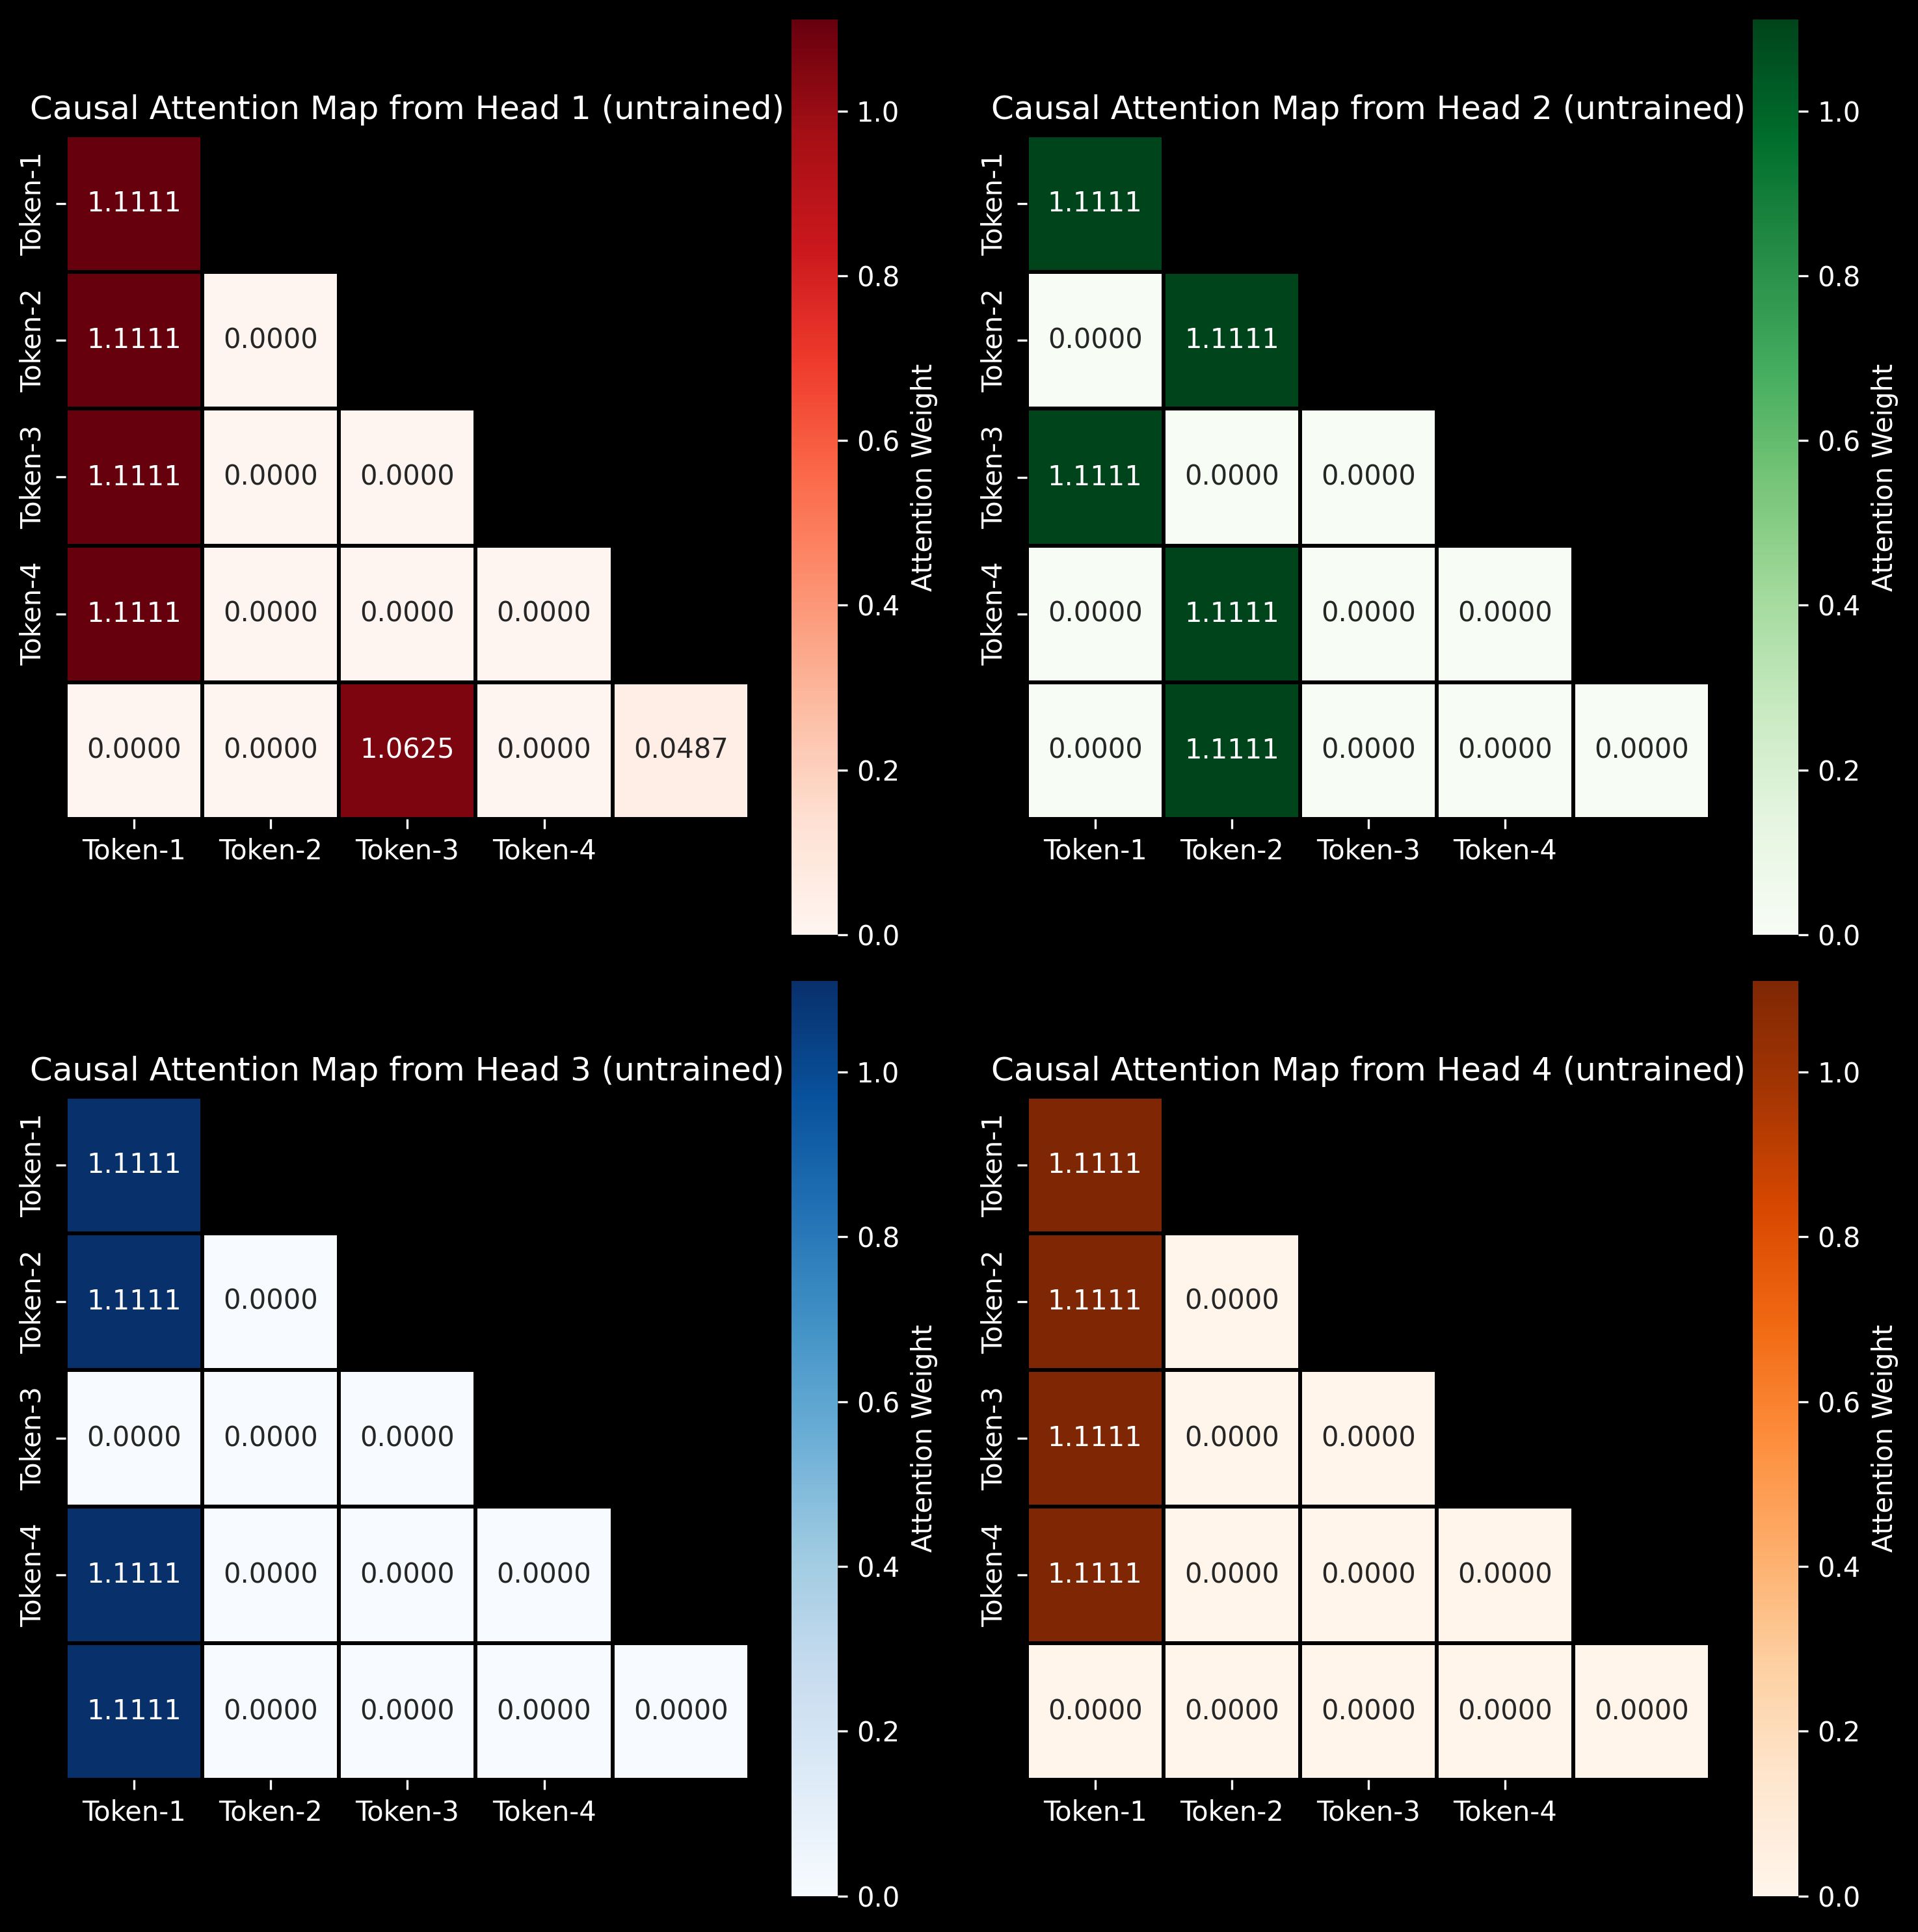

In [7]:
# Define ticklabels
ticklabels = [f'Token-{i}' for i in range(1, 5)]
cmaps = ['Reds', 'Greens', 'Blues', 'Oranges']
atw_list = [atw_111, atw_112, atw_113, atw_114]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=300)

# Plot each attention map in the corresponding subplot
for i, ax in enumerate(axes.flat):
    sns.heatmap(
        atw_list[i], 
        annot=True,
        mask=1 - np.tril(np.ones_like(atw_list[i])),
        annot_kws={'size': 10},
        fmt='.4f',
        cmap=cmaps[i],
        linewidths=1,
        linecolor='black',
        square=True,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
        cbar_kws={'label': 'Attention Weight'},
        ax=ax
    )
    ax.set_title(f'Causal Attention Map from Head {i+1} (untrained)')

plt.tight_layout()
plt.savefig('causal_attention_maps.png', dpi=300)
plt.show()